\# Developer: Ali Hashaam (ali.hashaam@initos.com) <br>
\# 2nd February 2019 <br>

\# © 2019 initOS GmbH <br>
\# License MIT <br>

\# Library for TSVM and SelfLearning taken from https://github.com/tmadl/semisup-learn <br>
\# Library for lagrangean-S3VM taken from https://github.com/fbagattini/lagrangean-s3vm <br>

In [1]:
import re, random, scipy
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from methods.qns3vm import QN_S3VM
from sklearn.metrics import classification_report
from lagrangian_s3vm import *
from utils import *
from sklearn.externals import joblib
from collections import Counter
import time
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

In [13]:
regex_square_brackets = re.compile(r'(\[)|(\])')
bugs = pd.read_csv('../datasets/lexical_semantic_preprocessed_mantis_bugs_less_columns_with_class_expansion.csv')
bug_notes = pd.read_csv('../datasets/lexical_semantic_preprocessed_mantis_bugnotes.csv')

bug_notes['bug_note'] = bug_notes['bug_note'].str.replace(regex_square_brackets, '')
bugs['additional_information'] = bugs['additional_information'].str.replace(regex_square_brackets, '')
bugs['description'] = bugs['description'].str.replace(regex_square_brackets, '')
bugs['summary'] = bugs['summary'].str.replace(regex_square_brackets, '')
df_bug_note_table = bug_notes.groupby(['bug_id'])['bug_note'].apply(','.join).to_frame('bug_notes').reset_index()

result = pd.merge(bugs, df_bug_note_table, how='left', left_on='id', right_on='bug_id')
result['textual_data'] = result['summary'].fillna('') + ',' + result['description'].fillna('') + ',' + result['additional_information'].fillna('') + ',' + result['bug_notes'].fillna('')
result['textual_data'] = result['textual_data'].str.replace(" ", "")
result.sort_values(by=['class'], inplace=True)
result.reset_index(drop=True, inplace= True)

In [14]:
result.loc[result['class']=='critical', 'class'] = -1
result.loc[result['class']=='non-critical', 'class'] = 1
unlabelled_index = result[(result['class'].isnull())].index
labelled_index = result[~(result['class'].isnull())].index
print result['class'].value_counts()

 1    2591
-1    1104
Name: class, dtype: int64


In [15]:
def lagrangian_s3vm(df, classifier_name):
    for no_of_features in [100, 500, 1000]:
        print("""####################### Running for Number of features {} ############################""".format(no_of_features))
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_of_features, stop_words='english')
        X = tfidf_vectorizer.fit_transform(df['textual_data'])
        Y = np.array(df['class'])
        #print("members for classes {}".format(",".join("(%s,%s)" % tup for tup in sorted(Counter(Y).items()))))
        X_U = X[unlabelled_index]
        X_l = X[labelled_index]
        Y_l = Y[labelled_index]
        stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.6, random_state=0)
        scores = []
        iteration = 1
        for train_index, test_index in stratified_shuffle_split.split(X_l, Y_l):
            X_train = X_l[train_index].copy()
            Y_train = Y_l[train_index].copy()
            X_test = X_l[test_index].copy()
            Y_test = Y_l[test_index].copy()
            svc = get_best_estimator_by_cv(X_train.toarray(), Y_train.astype(float), 5)
            classifier = lagrangian_s3vm_train(X_train.toarray(),
                                                  Y_train.astype(float),
                                                  X_U.toarray(),
                                                  svc,
                                                  r=0.5)
            joblib.dump(classifier, 'models/{}_{}_{}.pkl'.format(classifier_name, no_of_features, iteration))
            joblib.dump(X_test, 'models/X_test_{}_{}_{}.pkl'.format(classifier_name, no_of_features, iteration))
            joblib.dump(Y_test, 'models/Y_test_{}_{}_{}.pkl'.format(classifier_name, no_of_features, iteration))
            score = classifier.score(X_test.toarray(), Y_test.astype(float))
            scores.append(score)
            iteration += 1
        print "{} average score: {}".format(classifier_name, np.mean(scores))

In [17]:
start_time = time.time()
lagrangian_s3vm(result, 'Lagrangian S3VM')
print("--- %s seconds ---" % (time.time() - start_time))

####################### Running for Number of features 100 ############################
Lagrangian S3VM average score: 0.801533603969
####################### Running for Number of features 500 ############################
Lagrangian S3VM average score: 0.823635543527
####################### Running for Number of features 1000 ############################
Lagrangian S3VM average score: 0.822282363554
--- 150.562000036 seconds ---


In [18]:
# took --- 170.966814041 seconds --- to execute

In [8]:
def get_results(classifier):
    dict_features = {}
    dict_acc = {}
    for features in [500]:
        model = joblib.load('models/{}_{}_{}.pkl'.format(classifier, features, 1))
        x_tst = joblib.load('models/X_test_{}_{}_{}.pkl'.format(classifier, features, 1))
        y_tst = joblib.load('models/Y_test_{}_{}_{}.pkl'.format(classifier, features, 1))
        acc = model.score(x_tst.toarray(), y_tst.astype(int))
        y_pred = model.predict(x_tst.toarray())
        result = classification_report(y_tst.astype(int), y_pred.astype(int), output_dict=True)
        dict_features[str(features)] = pd.DataFrame(result)
        dict_features[str(features)].transpose().to_csv('{}_{}_latex_table_report.csv'.format(classifier, features))
        dict_acc[str(features)] = acc
    print dict_features['500']
    arrays = [["Precision", "Precision", "Precision", "Recall", "Recall", "Recall", "F1-score", "F1-score", 
               "F1-score"], ['Critical', 'Non-Critical', 'Weighted Avg.', 'Critical', 'Non-Critical', 
                                       'Weighted Avg.', 'Critical', 'Non-Critical', 'Weighted Avg.']]
    MI = pd.MultiIndex.from_arrays(arrays, names=('Measures', 'Classes'))
    vals = [[round(dict_features[str(features)].loc['precision', '-1'], 2)],
             [round(dict_features[str(features)].loc['precision', '1'], 2)],
             [round(dict_features[str(features)].loc['precision', 'weighted avg'], 2)],
             [round(dict_features[str(features)].loc['recall', '-1'], 2)],
             [round(dict_features[str(features)].loc['recall', '1'], 2)],
             [round(dict_features[str(features)].loc['recall', 'weighted avg'], 2)],
             [round(dict_features[str(features)].loc['f1-score', '-1'], 2)],
             [round(dict_features[str(features)].loc['f1-score', '1'], 2)],
             [round(dict_features[str(features)].loc['f1-score', 'weighted avg'], 2)]]
             #[round(dict_acc[str(features)],2)]]
    df = pd.DataFrame(vals, index=MI, columns=['vals'])  
    df = df.unstack().transpose().reset_index(level=0, drop=True)
    ax = df.plot(kind='bar', figsize=(8,6), rot=False)
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(patches, labels, loc='upper left')
    #vals = [[round(dict_features['500'].loc['precision', 'weighted avg'], 2), 
    #         round(dict_features['500'].loc['recall', 'weighted avg'], 2),
    #         round(dict_features['500'].loc['f1-score', 'weighted avg'], 2),
    #         round(dict_acc['500'],2)]]
    #columns=["Precision", "Recall", "F1-score", "Accuracy"]
    #df = pd.DataFrame(vals, columns=columns)  
    #df = df.transpose()
    #ax = df.plot(kind='bar', figsize=(8,6), rot=False, legend=False)
    plt.xlabel('Evaluation Measure {}'.format(classifier), fontsize=12)
    plt.savefig('{}_results.pdf'.format(classifier), dpi=720)
    
    return df

                   -1            1    macro avg    micro avg  weighted avg
f1-score     0.650581     0.882051     0.766316     0.823636      0.812934
precision    0.796499     0.830682     0.813590     0.823636      0.820475
recall       0.549849     0.940193     0.745021     0.823636      0.823636
support    662.000000  1555.000000  2217.000000  2217.000000   2217.000000


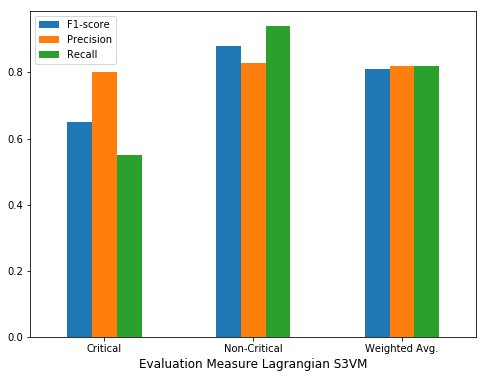

In [9]:
df = get_results('Lagrangian S3VM')